# Predictor Variable Sampling

The purpose of this notebook is to download to sample the geospatial features of the GPR model at the locations of the training data. For the objectives of this exercise, a few, readily-available features were selected for our model training. 

#### Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray
import fiona
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import zipfile
import tarfile
from shapely.geometry import Point

____________________

#### Load training data points

In [2]:
# Load the training data CSV file compiled in `1-data_access.ipynb`
input_file = '../data/1-uw_layer1_data.csv'
training_data = pd.read_csv(input_file)

# Create a GeoDataFrame from the DataFrame
training_data = gpd.GeoDataFrame(training_data, geometry=gpd.points_from_xy(training_data.LONGITUDE, training_data.LATITUDE))
    
# Set the CRS to WGS84 (latitude and longitude)
training_data.set_crs(epsg=4326, inplace=True)

training_data

,BOREHOLE_ID,BOREHOLE_NAME,BOREHOLE_TYPE,BOREHOLE_DEPTH_FT,ELEVATION_FT,LATITUDE,LONGITUDE,LAYER_NUMBER,TOP_DEPTH_FT,BOTTOM_DEPTH_FT,USCS,SIMPLE_USCS,LAYER_THICKNESS_FT,geometry
0,7138,B-1,Geotechnical,20.3,167.8,47.656719,-122.305728,1,0.0,1.0,SP,S,1.0,POINT (-122.30573 47.65672)
1,7143,B-1-92,Geotechnical,48.5,123.2,47.653642,-122.306837,1,0.0,1.0,ML,M,1.0,POINT (-122.30684 47.65364)
2,7144,B-2-92,Geotechnical,42.5,122.9,47.653766,-122.306468,1,0.0,1.0,ML,M,1.0,POINT (-122.30647 47.65377)
3,7145,B-3-92,Geotechnical,43.0,117.3,47.653256,-122.306638,1,0.0,1.0,ML,M,1.0,POINT (-122.30664 47.65326)
4,7146,B-4-92,Geotechnical,43.0,123.4,47.653709,-122.306259,1,0.0,0.5,SM,S,0.5,POINT (-122.30626 47.65371)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,143845,MW-1,Geotechnical,42.0,217.4,47.661044,-122.342453,1,0.0,7.5,SM,S,7.5,POINT (-122.34245 47.66104)
502,143846,MW-2,Geotechnical,43.0,218.2,47.661138,-122.342516,1,0.0,7.5,SM,S,7.5,POINT (-122.34252 47.66114)
503,143847,MW-3,Geotechnical,45.5,219.3,47.661276,-122.342492,1,0.0,18.0,SM,S,18.0,POINT (-122.34249 47.66128)
504,143848,MW-4,Geotechnical,43.0,219.1,47.661177,-122.342383,1,0.0,10.0,SM,S,10.0,POINT (-122.34238 47.66118)


____________________

#### Download geospatial predictor variables

Surface Geologic Map

In [3]:
# Define the URL and save path for the zip file
url = 'https://fortress.wa.gov/dnr/geologydata/publications/data_download/ger_portal_surface_geology_24k.zip'
save_path = '../data/temp/ger_portal_surface_geology_24k.zip'
extract_path = '../data/temp/geo_files/'

# Ensure the target folders exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)
os.makedirs(extract_path, exist_ok=True)

In [4]:
try:
    with requests.get(url, stream=True) as response:
        response.raise_for_status()
        with open(save_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):  # Download in chunks
                file.write(chunk)
    print(f"Downloaded file saved to {save_path}")
except requests.exceptions.RequestException as e:
    print(f"Failed to download the file. Error: {e}")
    exit(1)

Downloaded file saved to ../data/temp/ger_portal_surface_geology_24k.zip


In [5]:
# Check if the file is a valid ZIP file and extract files
if zipfile.is_zipfile(save_path):
    try:
        with zipfile.ZipFile(save_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(f"Files extracted to {extract_path}")
    except zipfile.BadZipFile as e:
        print(f"Error: The file at {save_path} is a bad ZIP file. {str(e)}")
else:
    print(f"Error: The file at {save_path} is not recognized as a valid ZIP file.")

Files extracted to ../data/temp/geo_files/


In [6]:
# View the extracted files
extracted_files = os.listdir(extract_path)
print(f"Extracted files: {extracted_files}")

Extracted files: ['layer_file', 'Surface_geology_24k.mpkx', '.ipynb_checkpoints', 'metadata', 'WGS_Surface_Geology_24k.gdb', 'README_surface_geology_24k.doc']


DEM-Derived Topographic Slope (90m resolution)

In [7]:
url = 'https://opentopography.s3.sdsc.edu/dataspace/OTDS.012020.4326.1/raster/slope/'
save_path = '../data/temp/slope_data.zip'
slope_extract_path = '../data/temp/slope_files/'

file = f'slope_90M_n30w150.tar.gz'
file_url = url + file

# download tar.gz file
response = requests.get(file_url)
with open(save_path, 'wb') as f:
    f.write(response.content)

with tarfile.open(save_path, "r:gz") as tar:
    tar.extractall(slope_extract_path)

DEM-Derived Roughness (90m resolution)

In [8]:
url = 'https://opentopography.s3.sdsc.edu/dataspace/OTDS.012020.4326.1/raster/roughness/'
save_path = '../data/temp/roughness_data.zip'
roughness_extract_path = '../data/temp/roughness_files/'

file = f'roughness_90M_n30w150.tar.gz'
file_url = url + file

# download tar.gz file
response = requests.get(file_url)
with open(save_path, 'wb') as f:
    f.write(response.content)

with tarfile.open(save_path, "r:gz") as tar:
    tar.extractall(roughness_extract_path)

____________________

#### Sample predictor variables at training data locations

Surface Geology Map

In [9]:
# Open the geodatabase file: 'WGS_Subsurface_Database.gdb' in the extracted files
gdb_path = os.path.join(extract_path, 'WGS_Surface_Geology_24k.gdb') 

# List all layers in the geodatabase
layers = fiona.listlayers(gdb_path)
print(f"Layers in the geodatabase: {layers}")

# We are interested in the geologic_unit_poly layer table
geologic_unit_poly = gpd.read_file(gdb_path, layer='geologic_unit_poly')
print(f"Shape of the layer_data table: {geologic_unit_poly.shape}")

print("Columns:", geologic_unit_poly.columns)

# Display the first few rows of the geologic_unit_poly table
# geologic_unit_poly.head()

Layers in the geodatabase: ['dike', 'fault', 'fold', 'geologic_date', 'map_line', 'map_point', 'misc_polygon', 'volcanic_vent', 'map_index', 'contact', 'attitude_point', 'unit_description', 'geologic_unit_poly']


/srv/conda/envs/notebook/lib/python3.11/site-packages/pyogrio/raw.py:196: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  return ogr_read(


Shape of the layer_data table: (82692, 10)
Columns: Index(['GUNIT_TXT', 'COMMENTS', 'PUB_SOURCE', 'PUB_NUMBER', 'QUAD_NAME',
       'FEATURE_LINK', 'AGE_LITHOLOGY', 'Shape_Length', 'Shape_Area',
       'geometry'],
      dtype='object')


In [10]:
# Process the FEATURE_LINK to keep only the last "cell" (e.g., 'Qvt')
geologic_unit_poly['FEATURE_LINK'] = geologic_unit_poly['FEATURE_LINK'].apply(lambda x: x.split('|')[-1].strip())

# Ensure that the CRS matches, reproject if necessary
geologic_unit_poly = geologic_unit_poly.to_crs(training_data.crs)

# Sample the geologic_unit_poly layer at the training data points
# Spatial join between training data points and geologic_unit_poly
sampled_data = gpd.sjoin(training_data, geologic_unit_poly, how='left', predicate='intersects')

# Add column to training data
training_data['MAPPED_UNIT'] = sampled_data['FEATURE_LINK']

# Clear up memory
del sampled_data

DEM-Derived Topographic Slope (90m resolution)

In [11]:
file = os.path.join(slope_extract_path,'slope_90M_n45w125.tif')

# Extract all x and y coordinates from the GeoDataFrame
xs = training_data.LONGITUDE
ys = training_data.LATITUDE
data = rioxarray.open_rasterio(file, masked=True).squeeze()

# Vectorized extraction of values 
extracted_values = data.sel(x=xr.DataArray(xs, dims="z"), y=xr.DataArray(ys, dims="z"), method="nearest", tolerance=0.01)

# Assign all the computed values to the DataFrame
training_data['SLOPE'] = extracted_values
training_data['SLOPE'].describe()

count    506.000000
mean       3.709318
std        1.791787
min        0.621623
25%        2.667529
50%        3.678473
75%        4.417787
max       11.087843
Name: SLOPE, dtype: float64

DEM-Derived Roughness (90m resolution)

In [12]:
file = os.path.join(roughness_extract_path,'roughness_90M_n45w125.tif')

# Extract all x and y coordinates from the GeoDataFrame
xs = training_data.LONGITUDE
ys = training_data.LATITUDE

data = rioxarray.open_rasterio(file, masked=True).squeeze()

# Vectorized extraction of values 
extracted_values = data.sel(x=xr.DataArray(xs, dims="z"), y=xr.DataArray(ys, dims="z"), method="nearest", tolerance=0.01)

# Assign all the computed values to the DataFrame
training_data['ROUGHNESS'] = extracted_values
training_data['ROUGHNESS'].describe()

count    506.000000
mean      17.175102
std        7.191712
min        3.951066
25%       12.683445
50%       16.924931
75%       20.515266
max       43.658848
Name: ROUGHNESS, dtype: float64

____________________

#### View and save the training data with features

In [13]:
# Display the unique values in the 'MAPPED_UNIT' column and their counts
geo_counts = training_data['MAPPED_UNIT'].value_counts()
print(geo_counts)

MAPPED_UNIT
Qvt    359
Qva     32
Qp      31
Qvr     20
Ql      19
Qvi     16
Qal      9
Qw       7
Qpf      6
Qpo      5
wtr      2
Name: count, dtype: int64


<Axes: xlabel='SLOPE', ylabel='Count'>

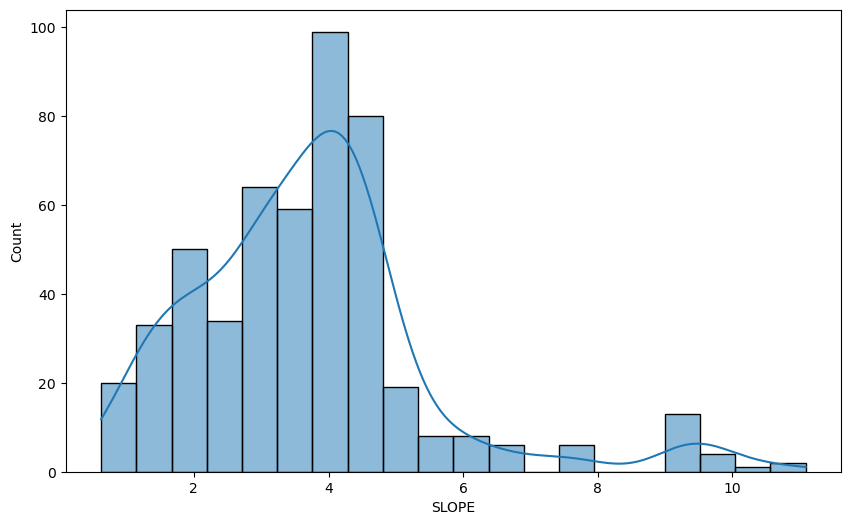

In [14]:
# Make a histogram of the slope values
plt.figure(figsize=(10, 6))
sns.histplot(training_data['SLOPE'], bins=20, kde=True)

<Axes: xlabel='ROUGHNESS', ylabel='Count'>

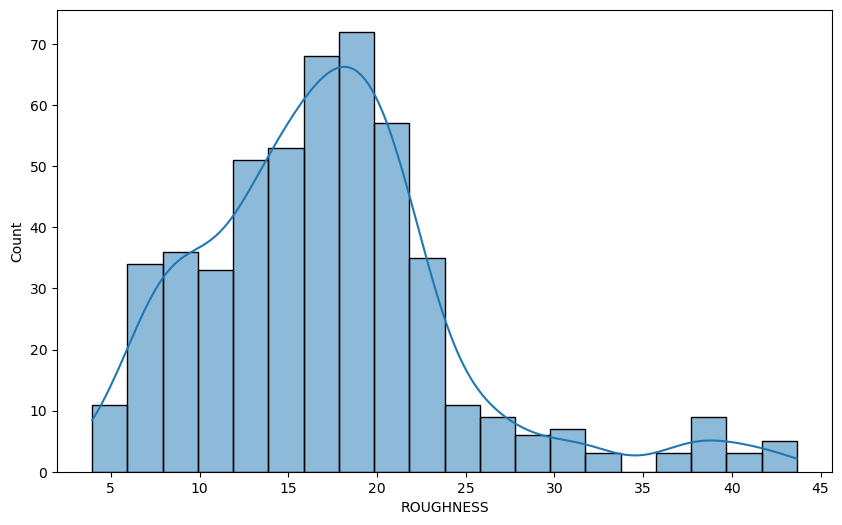

In [15]:
# Make a histogram of the roughness values
plt.figure(figsize=(10, 6))
sns.histplot(training_data['ROUGHNESS'], bins=20, kde=True)

In [16]:
# Save the training data to a new CSV file
output_file = '../data/2-uw_layer1_trainingdata.csv'
training_data.to_csv(output_file, index=False)

____________________

Sources:
1. Amatulli, G., McInerney, D., Sethi, T. et al. Geomorpho90m, empirical evaluation and accuracy assessment of global high-resolution geomorphometric layers. Sci Data 7, 162 (2020). https://doi.org/10.1038/s41597-020-0479-6
2. Washington Geological Survey, 2023, Surface geology, 1:24,000--GIS data, January 2023: Washington Geological Survey Digital Data Series DS-10, version 3.2, previously released November 2019. https://www.dnr.wa.gov/publications/ger_portal_surface_geology_24k.zip